In [1]:
!pip install pyinform

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import entropy
from pyinform.transferentropy import transfer_entropy
import os

## Transfer Entropy Analysis

Analyzing Bladder Cancer Data...
Features shape: (1056, 6, 616)
Targets shape: (1056,)
Index shape: (1056, 2)
Detected 3D features array with shape (1056, 6, 616)
Using time slice 0, new shape: (1056, 616)
(1056, 619)
  geo_code  year  feature_0  feature_1  feature_2  feature_3  feature_4  \
0       11  1999    15915.0    29614.0    22185.0        0.0        0.0   
1       11  2000    20949.0    26530.0    26096.0     4529.0        0.0   
2       11  2001    24638.0    22923.0    33594.0     8708.0        0.0   
3       11  2002    21637.0    17312.0    30272.0     8737.0        0.0   
4       11  2003    18483.0    11537.0    25883.0     8739.0        0.0   

   feature_5  feature_6  feature_7  ...  feature_607  feature_608  \
0    44210.0        0.0      214.0  ...          0.0          0.0   
1    51647.0        0.0      230.0  ...          0.0          0.0   
2    50282.0        0.0      183.0  ...          0.0          0.0   
3    43298.0        0.0      172.0  ...          0.0   

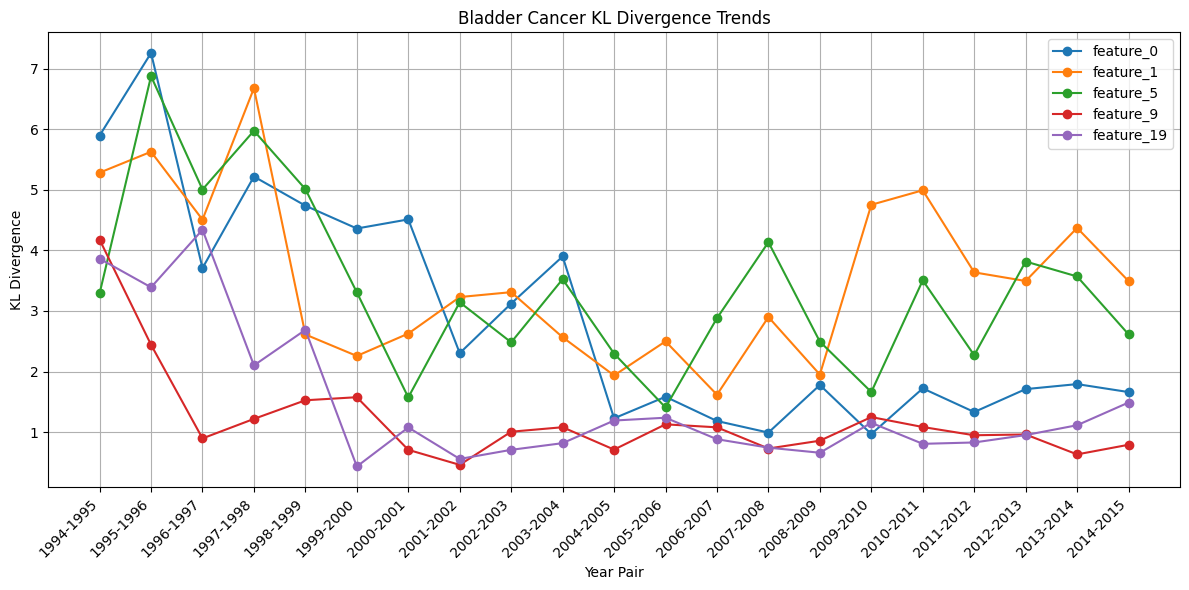

Analyzing Lung Cancer Data...
Features shape: (932, 10, 728)
Targets shape: (932,)
Index shape: (932, 2)
Detected 3D features array with shape (932, 10, 728)
Using time slice 0, new shape: (932, 728)
(932, 731)
  geo_code  year  feature_0  feature_1  feature_2  feature_3  feature_4  \
0       11  1999        0.0    15436.0      835.0       48.0    14032.0   
1       11  2000        0.0    31947.0     1276.0      193.0    15522.0   
2       11  2001        0.0    34000.0     1137.0      178.0    16874.0   
3       11  2002        0.0    34916.0      791.0      182.0    17099.0   
4       11  2003        0.0    44210.0      786.0      180.0    22185.0   

   feature_5  feature_6  feature_7  ...  feature_719  feature_720  \
0    13973.0     7976.0       56.0  ...          0.0          0.0   
1    19992.0    10422.0      147.0  ...          0.0          0.0   
2    27036.0    12119.0      167.0  ...          0.0          0.0   
3    33412.0    12261.0      178.0  ...          0.0          

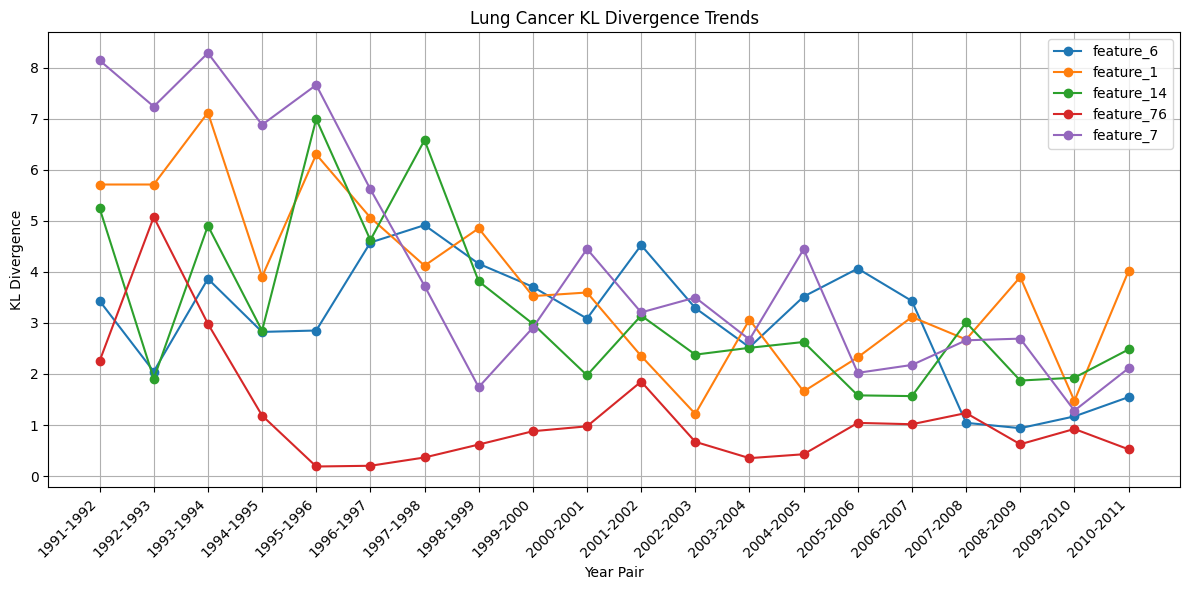


Common high entropy features: ['feature_1']

Analyzing transfer entropy between bladder and lung cancer data...

Transfer Entropy Analysis for: feature_1
TE(Bladder → Lung): 0.8477
TE(Lung → Bladder): 0.8477

Transfer Entropy Summary:

feature_1:
  Bladder → Lung: 0.8477
  Lung → Bladder: 0.8477
  Lung has stronger influence on Bladder by 0.0000


In [3]:
def calculate_mutual_information(x, y, bins=10):
    # Convert to numpy arrays if needed
    x = np.array(x)
    y = np.array(y)

    # Create histograms
    hist_x, bin_edges_x = np.histogram(x, bins=bins)
    hist_y, bin_edges_y = np.histogram(y, bins=bins)

def load_data(model_type, base_path):
    features = np.load(f'{base_path}{model_type}_features.npy')
    targets = np.load(f'{base_path}{model_type}_target.npy')
    index = np.load(f'{base_path}{model_type}_index.npy')

    print(f"Features shape: {features.shape}")
    print(f"Targets shape: {targets.shape}")
    print(f"Index shape: {index.shape}")

    return features, targets, index

def calculate_entropy_for_features(data, exclude_cols=None):
    if exclude_cols is None:
        exclude_cols = []

    entropy_dict = {}

    # If data is a DataFrame, iterate through columns
    if isinstance(data, pd.DataFrame):
        for col in data.columns:
            if col in exclude_cols:
                continue

            counts = data[col].value_counts(normalize=True)
            probabilities = counts / counts.sum()
            col_entropy = entropy(probabilities, base=2)
            entropy_dict[col] = col_entropy
    # If data is a NumPy array, iterate through features
    else:
        for i in range(data.shape[1]):
            # Create bins for continuous data
            counts, _ = np.histogram(data[:, i], bins=50, density=True)
            # Add small constant to avoid zeros
            counts = counts + 1e-9
            # Normalize
            probabilities = counts / counts.sum()
            col_entropy = entropy(probabilities, base=2)
            entropy_dict[f'feature_{i}'] = col_entropy

    return pd.Series(entropy_dict)

def calculate_kl_divergence_across_years(data, features, years_col='year'):
    years = sorted(data[years_col].unique())
    year_labels = [f"{years[i]}-{years[i+1]}" for i in range(len(years)-1)]
    kl_divergences = {feature: [] for feature in features}

    for feature in features:
        print(f'\nKL Divergence for: {feature}')

        # Prepare distributions per year
        year_distributions = {}
        for year in years:
            # Get data for this year and feature
            year_data = data[data[years_col] == year][feature].dropna() + 1e-9

            # Bin the data to create a probability distribution
            counts, bin_edges = np.histogram(year_data, bins=50, density=True)
            counts = counts + 1e-9  # avoid zeros
            year_distributions[year] = counts / counts.sum()

        # Compare consecutive years
        for i in range(len(years) - 1):
            year1 = years[i]
            year2 = years[i + 1]

            p = year_distributions[year1]
            q = year_distributions[year2]

            kl_div = entropy(p, q)
            kl_divergences[feature].append(kl_div)
            print(f'KL({year1} || {year2}): {kl_div:.4f}')

    return kl_divergences, year_labels

def plot_kl_divergence(kl_divergences, year_labels, title='KL Divergence Trends'):
    plt.figure(figsize=(12, 6))

    for feature, kl_values in kl_divergences.items():
        plt.plot(year_labels, kl_values, marker='o', label=feature)

    plt.title(title)
    plt.xlabel('Year Pair')
    plt.xticks(rotation=45, ha='right')
    plt.ylabel('KL Divergence')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()

    # Save BEFORE plt.show() and explicitly disable transparency
    save_path = f'{title.replace(" ", "_")}.eps'
    plt.savefig(save_path, format='eps', bbox_inches='tight', dpi=300)

    # Optionally export a fallback PNG as well
    plt.savefig(save_path.replace(".eps", ".png"), dpi=300)

    plt.show()

def analyze_cancer_data(model_type, base_path=''):
    print(f"Analyzing {model_type.capitalize()} Cancer Data...")

    # Load cancer data from .npy files
    features, targets, index = load_data(model_type, base_path)

    # Handle 3D features array
    if len(features.shape) == 3:
        print(f"Detected 3D features array with shape {features.shape}")
        time_slice = 0  # Use the first time slice
        features_2d = features[:, time_slice, :]
        print(f"Using time slice {time_slice}, new shape: {features_2d.shape}")
    else:
        features_2d = features

    # Create DataFrame for index data with dynamic column assignment
    if len(index.shape) == 1:
        # Single dimension index
        index_df = pd.DataFrame(index, columns=['index'])
    else:
        # Multi-dimensional index
        if index.shape[1] == 2:
            # If there are only 2 columns, assume they are geo_code and year
            index_columns = ['geo_code', 'year']
        elif index.shape[1] == 3:
            # If there are 3 columns, use the original names
            index_columns = ['geo_code', 'year', 'county_count']
        else:
            # For any other number, use generic names
            index_columns = [f'index_{i}' for i in range(index.shape[1])]

        index_df = pd.DataFrame(index, columns=index_columns)

    # Feature columns - depends on your data structure
    feature_columns = [f'feature_{i}' for i in range(features_2d.shape[1])]
    features_df = pd.DataFrame(features_2d, columns=feature_columns)

    # Combine them
    cancer_df = pd.concat([index_df, features_df], axis=1)
    cancer_df['target'] = targets

    print(cancer_df.shape)
    print(cancer_df.head())

    # Calculate entropy for features
    entropy_dict = calculate_entropy_for_features(features_df)

    # Get top k high and low entropy features
    k = 5
    top_k_high_entropy = entropy_dict.sort_values(ascending=False).head(k)
    top_k_low_entropy = entropy_dict[entropy_dict > 0].sort_values(ascending=True).head(k)

    print(f"Top {k} features with highest entropy:")
    print(top_k_high_entropy)

    print(f"\nTop {k} features with lowest entropy:")
    print(top_k_low_entropy)

    # Select top 5 features for KL divergence analysis
    top_5_features = top_k_high_entropy.index.tolist()

    # Calculate KL divergence - ensure 'year' column exists
    years_col = 'year' if 'year' in cancer_df.columns else index_columns[1]  # Use the second column if no 'year'

    kl_divergences, year_labels = calculate_kl_divergence_across_years(
        cancer_df, top_5_features, years_col=years_col
    )

    # Plot KL divergence
    plot_kl_divergence(kl_divergences, year_labels, title=f'{model_type.capitalize()} Cancer KL Divergence Trends')

    return cancer_df, top_5_features

def calculate_transfer_entropy(data1, data2, k=3, delay=1):
    # Convert to numpy arrays if needed
    data1 = np.array(data1)
    data2 = np.array(data2)

    # Check for NaN values
    if np.isnan(data1).any() or np.isnan(data2).any():
        print("Warning: NaN values detected in time series. Using correlation as fallback.")
        # Use correlation as fallback
        valid_indices = ~np.isnan(data1) & ~np.isnan(data2)
        if valid_indices.sum() > 1:
            corr = np.corrcoef(data1[valid_indices], data2[valid_indices])[0, 1]
            return abs(corr)
        else:
            return 0.0

    # pyinform requires positive integers for time series
    # Discretize the data by binning
    def discretize(x, bins=4):
        # Remove any NaN values
        x = x[~np.isnan(x)]
        if len(x) == 0:
            return np.array([])

        # Create bins
        bin_edges = np.linspace(np.min(x) - 1e-10, np.max(x) + 1e-10, bins + 1)
        # Digitize the data
        return np.digitize(x, bin_edges[:-1])

    # Discretize both time series
    data1_discrete = discretize(data1)
    data2_discrete = discretize(data2)

    # Check if discretization succeeded
    if len(data1_discrete) == 0 or len(data2_discrete) == 0:
        print("Warning: Discretization failed. Using correlation as fallback.")
        return np.corrcoef(data1, data2)[0, 1]

    # Use pyinform's transfer_entropy with discretized data
    te = transfer_entropy(data1_discrete, data2_discrete, k=k, local=False)

    return te

def analyze_transfer_entropy(bladder_df, lung_df, top_features, years_col='year'):
    te_results = {}

    # Make sure the years column exists in both dataframes
    if years_col not in bladder_df.columns:
        if 'index_1' in bladder_df.columns:
            years_col = 'index_1'
        else:
            print(f"Warning: Could not find years column. Available columns: {bladder_df.columns}")
            return {}

    years = sorted(bladder_df[years_col].unique())

    for feature in top_features:
        print(f"\nTransfer Entropy Analysis for: {feature}")

        # Extract time series for this feature across years
        bladder_ts = []
        lung_ts = []

        for year in years:
            # Get mean value for each year
            bladder_mean = bladder_df[bladder_df[years_col] == year][feature].mean()
            lung_mean = lung_df[lung_df[years_col] == year][feature].mean()

            bladder_ts.append(bladder_mean)
            lung_ts.append(lung_mean)

        # Calculate transfer entropy in both directions
        te_bladder_to_lung = calculate_transfer_entropy(np.array(bladder_ts), np.array(lung_ts))
        te_lung_to_bladder = calculate_transfer_entropy(np.array(lung_ts), np.array(bladder_ts))

        print(f"TE(Bladder → Lung): {te_bladder_to_lung:.4f}")
        print(f"TE(Lung → Bladder): {te_lung_to_bladder:.4f}")

        te_results[feature] = {
            'bladder_to_lung': te_bladder_to_lung,
            'lung_to_bladder': te_lung_to_bladder
        }

    return te_results

# Base path where .npy files are located
base_path = '/content/'  # For Google Colab

# Analyze both cancer types with generic analyzer
bladder_df, bladder_top_features = analyze_cancer_data('bladder', base_path)
lung_df, lung_top_features = analyze_cancer_data('lung', base_path)

# Find common top features for transfer entropy analysis
common_features = list(set(bladder_top_features).intersection(set(lung_top_features)))

print(f"\nCommon high entropy features: {common_features}")

# If there are common features, analyze transfer entropy
if common_features:
    print("\nAnalyzing transfer entropy between bladder and lung cancer data...")

    # Determine years column name
    years_col = 'year'
    if years_col not in bladder_df.columns:
        # Try to find the year column
        if 'index_1' in bladder_df.columns:
            years_col = 'index_1'
        else:
            for col in bladder_df.columns:
                if col.startswith('index_'):
                    years_col = col
                    break

    te_results = analyze_transfer_entropy(bladder_df, lung_df, common_features, years_col=years_col)

    # Summarize transfer entropy results
    print("\nTransfer Entropy Summary:")
    for feature, results in te_results.items():
        print(f"\n{feature}:")
        print(f"  Bladder → Lung: {results['bladder_to_lung']:.4f}")
        print(f"  Lung → Bladder: {results['lung_to_bladder']:.4f}")

        # Determine dominant direction
        if results['bladder_to_lung'] > results['lung_to_bladder']:
            difference = results['bladder_to_lung'] - results['lung_to_bladder']
            print(f"  Bladder has stronger influence on Lung by {difference:.4f}")
        elif results['lung_to_bladder'] > results['bladder_to_lung']:
            difference = results['lung_to_bladder'] - results['bladder_to_lung']
            print(f"  Lung has stronger influence on Bladder by {difference:.4f}")
        else:
            print("  Equal bidirectional influence")
else:
    print("\nNo common high entropy features found for transfer entropy analysis.")

Features shape: (1056, 6, 616)
Targets shape: (1056,)
Index shape: (1056, 2)
Features shape: (932, 10, 728)
Targets shape: (932,)
Index shape: (932, 2)
KL Divergence Analysis for Bladder Cancer:
Analyzing KL divergence for top 20 features by variance:
  Copper compounds (feature_41)
  Hydrochloric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size) (feature_19)
  Zinc compounds (feature_46)
  Lead compounds (feature_21)
  Nitrate compounds (water dissociable; reportable only when in aqueous solution) (feature_32)
  Manganese compounds (feature_10)
  Zinc (fume or dust) (feature_138)
  Chlorine (feature_105)
  Ammonia (feature_9)
  Barium compounds (except for barium sulfate (CAS No. 7727-43-7)) (feature_42)
  Sulfuric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size) (feature_35)
  Arsenic compounds (feature_52)
  Methanol (feature_8)
  Chromium compounds (except for chromite ore mined

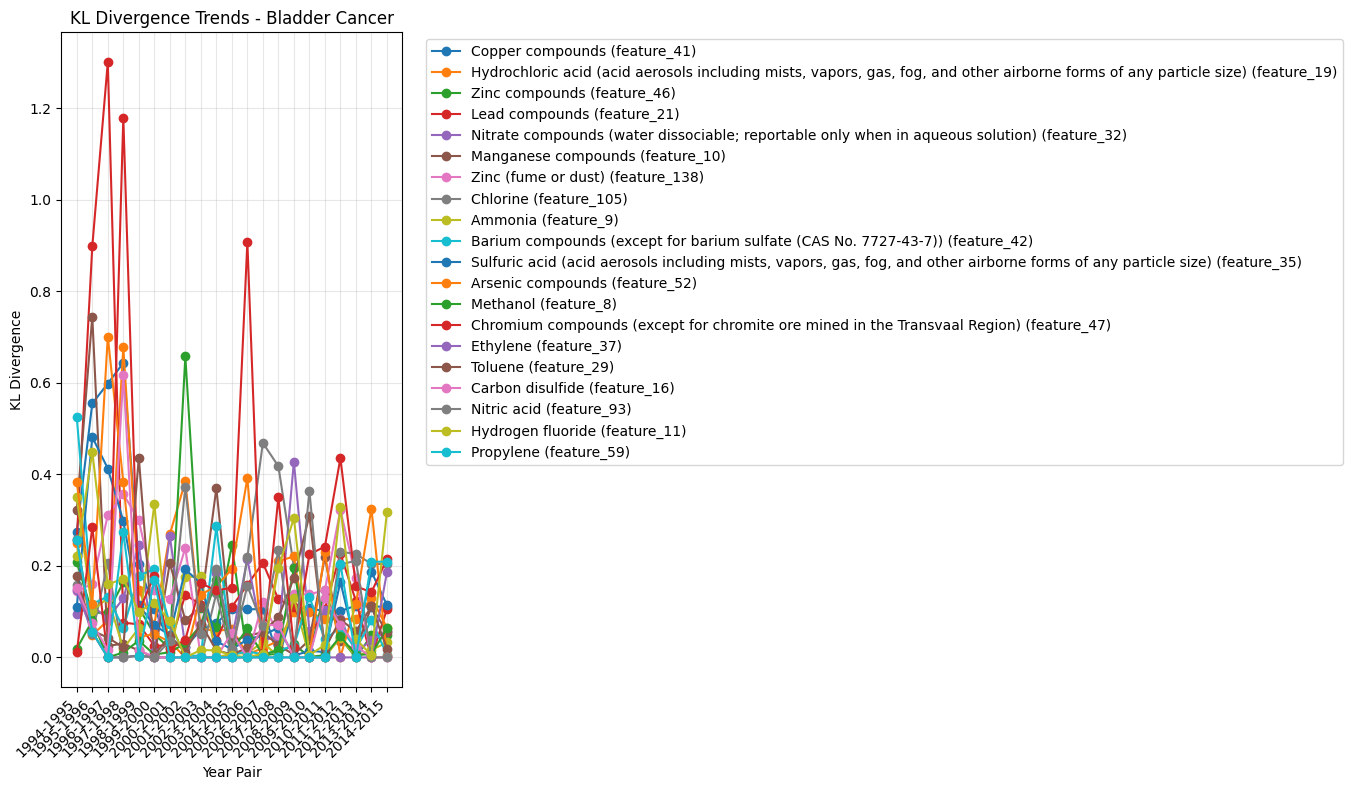


KL Divergence Analysis for Lung Cancer:
Analyzing KL divergence for top 20 features by variance:
  Copper compounds (feature_139)
  Hydrochloric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size) (feature_180)
  Zinc compounds (feature_274)
  Ammonia (feature_76)
  Lead compounds (feature_187)
  Nitrate compounds (water dissociable; reportable only when in aqueous solution) (feature_308)
  Chlorine (feature_122)
  Manganese compounds (feature_192)
  Zinc (fume or dust) (feature_273)
  Ammonium sulfate (solution) (feature_78)
  Sulfuric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size) (feature_250)
  Methanol (feature_196)
  Barium compounds (except for barium sulfate (CAS No. 7727-43-7)) (feature_87)
  Arsenic compounds (feature_84)
  Chromium compounds (except for chromite ore mined in the Transvaal Region) (feature_135)
  Ethylene (feature_165)
  Toluene (feature_259)
  Nitric aci

/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: divide by zero encountered in divide
  return n/db/n.sum(), bin_edges
/usr/local/lib/python3.11/dist-packages/numpy/lib/_histograms_impl.py:895: RuntimeWarning: invalid value encountered in divide
  return n/db/n.sum(), bin_edges


  KL(2001 || 2002): 0.0373
  KL(2002 || 2003): 0.0340
  KL(2003 || 2004): 0.0000
  KL(2004 || 2005): 0.1373
  KL(2005 || 2006): 0.1562
  KL(2006 || 2007): 0.1928
  KL(2007 || 2008): 0.3917
  KL(2008 || 2009): 0.0000
  KL(2009 || 2010): 0.2100
  KL(2010 || 2011): 0.2390

Analyzing KL divergence for: Chromium compounds (except for chromite ore mined in the Transvaal Region) (feature_135)
  KL(1991 || 1992): 0.1069
  KL(1992 || 1993): 0.1444
  KL(1993 || 1994): 0.0562
  KL(1994 || 1995): 0.2990
  KL(1995 || 1996): 0.2554
  KL(1996 || 1997): 0.0042
  KL(1997 || 1998): 0.0256
  KL(1998 || 1999): 0.1371
  KL(1999 || 2000): 0.0400
  KL(2000 || 2001): 0.2137
  KL(2001 || 2002): 0.1714
  KL(2002 || 2003): 0.0585
  KL(2003 || 2004): 0.0343
  KL(2004 || 2005): 0.2434
  KL(2005 || 2006): 0.1335
  KL(2006 || 2007): 0.2101
  KL(2007 || 2008): 0.6085
  KL(2008 || 2009): 0.3110
  KL(2009 || 2010): 0.2114
  KL(2010 || 2011): 0.0128

Analyzing KL divergence for: Ethylene (feature_165)
  KL(1991 || 1992)

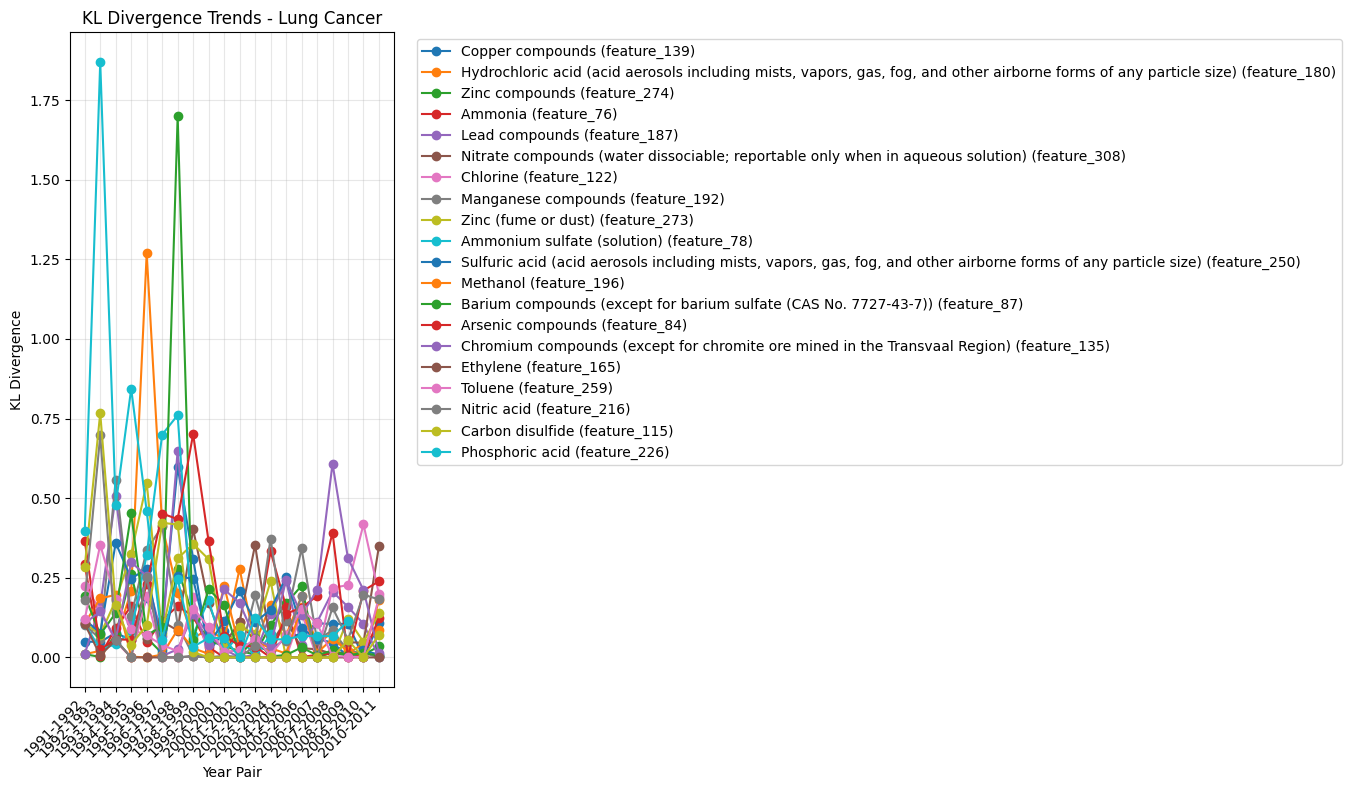


Comparing KL Divergence Patterns Between Cancer Types:
No common features found for comparison

Time Window Analysis for Bladder Cancer:

Analyzing KL divergence across time windows for top 5 features:

  Copper compounds (feature_41)
    KL(Time 0 || Time 1): 0.0000
    KL(Time 0 || Time 2): 0.0002
    KL(Time 0 || Time 3): 0.0002
    KL(Time 0 || Time 4): 0.0004
    KL(Time 0 || Time 5): 0.0006
    KL(Time 1 || Time 2): 0.0000
    KL(Time 1 || Time 3): 0.0001
    KL(Time 1 || Time 4): 0.0002
    KL(Time 1 || Time 5): 0.0005
    KL(Time 2 || Time 3): 0.0001
    KL(Time 2 || Time 4): 0.0002
    KL(Time 2 || Time 5): 0.0004
    KL(Time 3 || Time 4): 0.0000
    KL(Time 3 || Time 5): 0.0002
    KL(Time 4 || Time 5): 0.0000


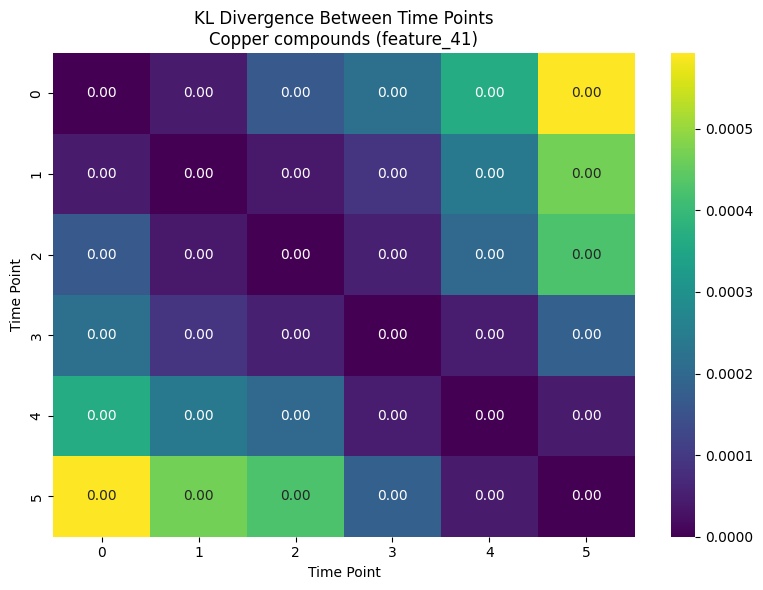


  Lead compounds (feature_21)
    KL(Time 0 || Time 1): 0.0003
    KL(Time 0 || Time 2): 0.0009
    KL(Time 0 || Time 3): 0.0013
    KL(Time 0 || Time 4): 0.0020
    KL(Time 0 || Time 5): 0.0029
    KL(Time 1 || Time 2): 0.0002
    KL(Time 1 || Time 3): 0.0005
    KL(Time 1 || Time 4): 0.0012
    KL(Time 1 || Time 5): 0.0021
    KL(Time 2 || Time 3): 0.0003
    KL(Time 2 || Time 4): 0.0009
    KL(Time 2 || Time 5): 0.0018
    KL(Time 3 || Time 4): 0.0002
    KL(Time 3 || Time 5): 0.0006
    KL(Time 4 || Time 5): 0.0001


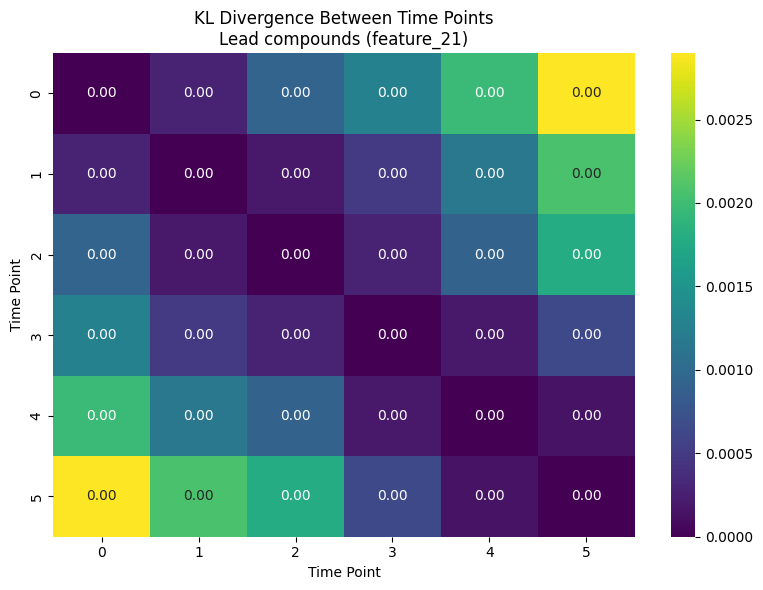


  Hydrochloric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size) (feature_19)
    KL(Time 0 || Time 1): 0.0003
    KL(Time 0 || Time 2): 0.0008
    KL(Time 0 || Time 3): 0.0009
    KL(Time 0 || Time 4): 0.0012
    KL(Time 0 || Time 5): 0.0014
    KL(Time 1 || Time 2): 0.0002
    KL(Time 1 || Time 3): 0.0002
    KL(Time 1 || Time 4): 0.0005
    KL(Time 1 || Time 5): 0.0007
    KL(Time 2 || Time 3): 0.0000
    KL(Time 2 || Time 4): 0.0001
    KL(Time 2 || Time 5): 0.0003
    KL(Time 3 || Time 4): 0.0001
    KL(Time 3 || Time 5): 0.0002
    KL(Time 4 || Time 5): 0.0001


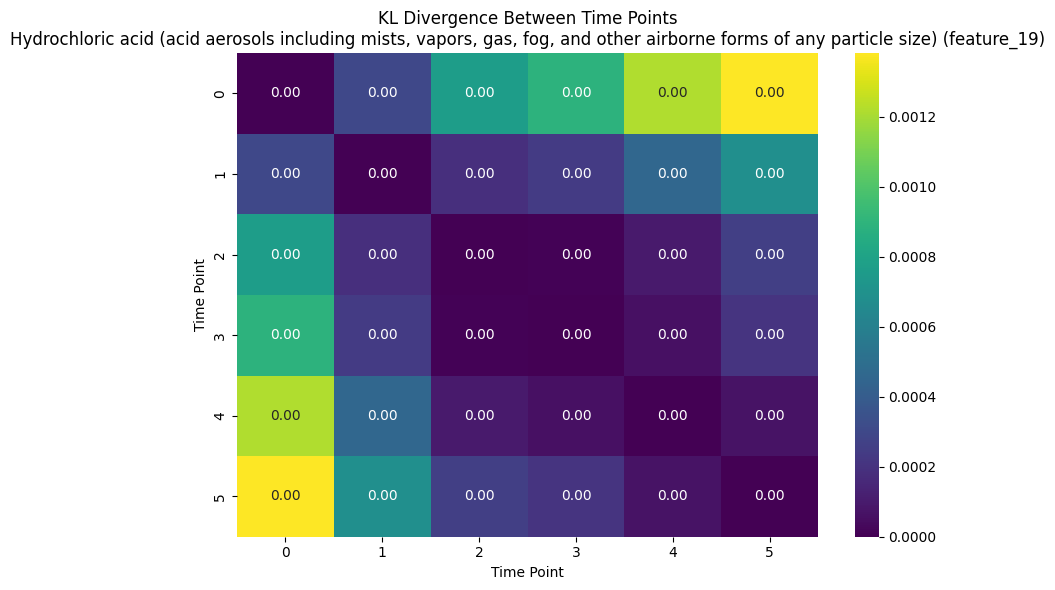


  Barium compounds (except for barium sulfate (CAS No. 7727-43-7)) (feature_42)
    KL(Time 0 || Time 1): 0.0008
    KL(Time 0 || Time 2): 0.0028
    KL(Time 0 || Time 3): 0.0040
    KL(Time 0 || Time 4): 0.0055
    KL(Time 0 || Time 5): 0.0067
    KL(Time 1 || Time 2): 0.0006
    KL(Time 1 || Time 3): 0.0013
    KL(Time 1 || Time 4): 0.0023
    KL(Time 1 || Time 5): 0.0031
    KL(Time 2 || Time 3): 0.0002
    KL(Time 2 || Time 4): 0.0007
    KL(Time 2 || Time 5): 0.0013
    KL(Time 3 || Time 4): 0.0002
    KL(Time 3 || Time 5): 0.0005
    KL(Time 4 || Time 5): 0.0002


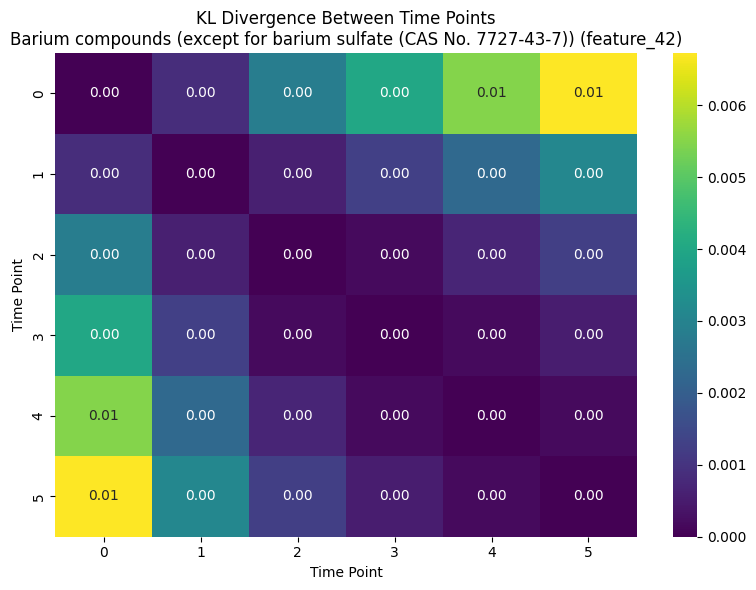


  Zinc compounds (feature_46)
    KL(Time 0 || Time 1): 0.0001
    KL(Time 0 || Time 2): 0.0005
    KL(Time 0 || Time 3): 0.0010
    KL(Time 0 || Time 4): 0.0013
    KL(Time 0 || Time 5): 0.0018
    KL(Time 1 || Time 2): 0.0001
    KL(Time 1 || Time 3): 0.0004
    KL(Time 1 || Time 4): 0.0006
    KL(Time 1 || Time 5): 0.0009
    KL(Time 2 || Time 3): 0.0001
    KL(Time 2 || Time 4): 0.0002
    KL(Time 2 || Time 5): 0.0004
    KL(Time 3 || Time 4): 0.0000
    KL(Time 3 || Time 5): 0.0002
    KL(Time 4 || Time 5): 0.0001


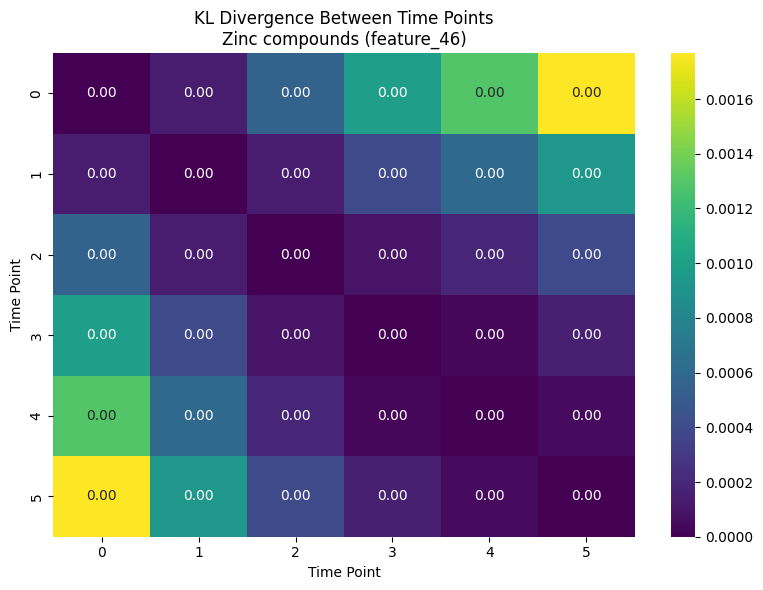


Time Window Analysis for Lung Cancer:

Analyzing KL divergence across time windows for top 5 features:

  Copper compounds (feature_139)
    KL(Time 0 || Time 1): 0.0001
    KL(Time 0 || Time 2): 0.0002
    KL(Time 0 || Time 3): 0.0005
    KL(Time 0 || Time 4): 0.0014
    KL(Time 0 || Time 5): 0.0014
    KL(Time 0 || Time 6): 0.0017
    KL(Time 0 || Time 7): 0.0018
    KL(Time 0 || Time 8): 0.0021
    KL(Time 0 || Time 9): 0.0024
    KL(Time 1 || Time 2): 0.0001
    KL(Time 1 || Time 3): 0.0003
    KL(Time 1 || Time 4): 0.0012
    KL(Time 1 || Time 5): 0.0013
    KL(Time 1 || Time 6): 0.0015
    KL(Time 1 || Time 7): 0.0016
    KL(Time 1 || Time 8): 0.0019
    KL(Time 1 || Time 9): 0.0022
    KL(Time 2 || Time 3): 0.0003
    KL(Time 2 || Time 4): 0.0011
    KL(Time 2 || Time 5): 0.0012
    KL(Time 2 || Time 6): 0.0014
    KL(Time 2 || Time 7): 0.0015
    KL(Time 2 || Time 8): 0.0018
    KL(Time 2 || Time 9): 0.0022
    KL(Time 3 || Time 4): 0.0003
    KL(Time 3 || Time 5): 0.0004
    

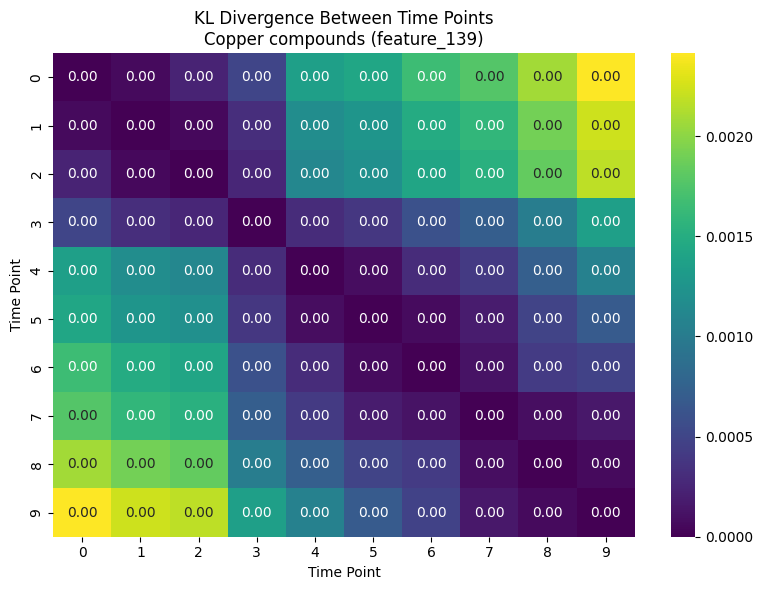


  Hydrochloric acid (acid aerosols including mists, vapors, gas, fog, and other airborne forms of any particle size) (feature_180)
    KL(Time 0 || Time 1): 0.0012
    KL(Time 0 || Time 2): 0.0034
    KL(Time 0 || Time 3): 0.0054
    KL(Time 0 || Time 4): 0.0074
    KL(Time 0 || Time 5): 0.0098
    KL(Time 0 || Time 6): 0.0123
    KL(Time 0 || Time 7): 0.0144
    KL(Time 0 || Time 8): 0.0155
    KL(Time 0 || Time 9): 0.0165
    KL(Time 1 || Time 2): 0.0009
    KL(Time 1 || Time 3): 0.0020
    KL(Time 1 || Time 4): 0.0034
    KL(Time 1 || Time 5): 0.0055
    KL(Time 1 || Time 6): 0.0084
    KL(Time 1 || Time 7): 0.0101
    KL(Time 1 || Time 8): 0.0113
    KL(Time 1 || Time 9): 0.0125
    KL(Time 2 || Time 3): 0.0005
    KL(Time 2 || Time 4): 0.0016
    KL(Time 2 || Time 5): 0.0032
    KL(Time 2 || Time 6): 0.0061
    KL(Time 2 || Time 7): 0.0077
    KL(Time 2 || Time 8): 0.0090
    KL(Time 2 || Time 9): 0.0104
    KL(Time 3 || Time 4): 0.0007
    KL(Time 3 || Time 5): 0.0018
    KL(Tim

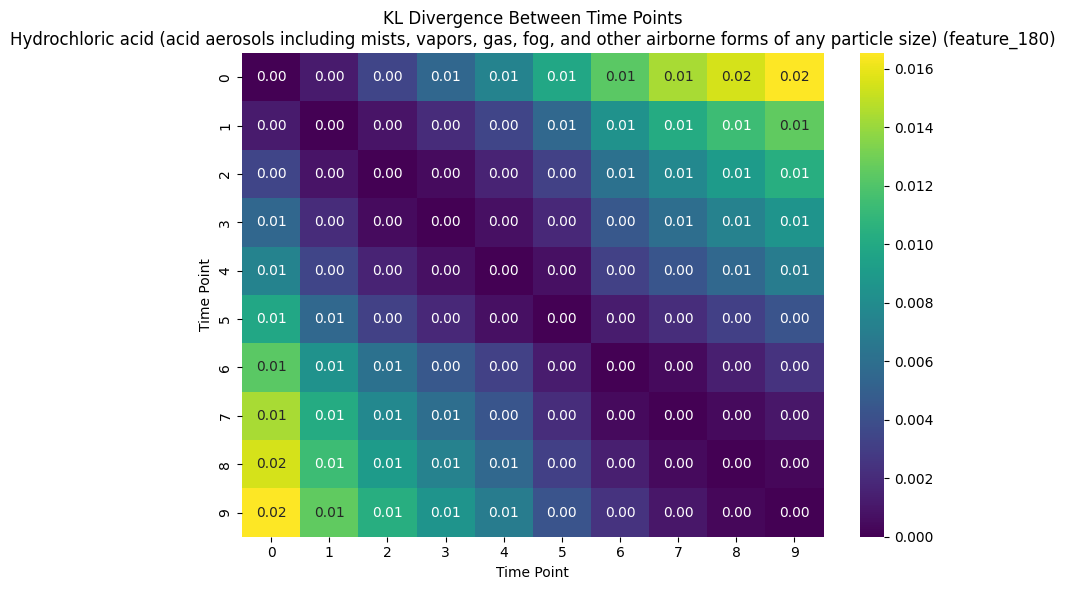


  Ammonium sulfate (solution) (feature_78)
    KL(Time 0 || Time 1): 0.0003
    KL(Time 0 || Time 2): 0.0017
    KL(Time 0 || Time 3): 0.0017
    KL(Time 0 || Time 4): 0.0017
    KL(Time 0 || Time 5): 0.0017
    KL(Time 0 || Time 6): 0.0017
    KL(Time 0 || Time 7): 0.0017
    KL(Time 0 || Time 8): 0.0017
    KL(Time 0 || Time 9): 0.0017
    KL(Time 1 || Time 2): 0.0005
    KL(Time 1 || Time 3): 0.0005
    KL(Time 1 || Time 4): 0.0005
    KL(Time 1 || Time 5): 0.0005
    KL(Time 1 || Time 6): 0.0005
    KL(Time 1 || Time 7): 0.0005
    KL(Time 1 || Time 8): 0.0005
    KL(Time 1 || Time 9): 0.0005
    KL(Time 2 || Time 3): 0.0044
    KL(Time 2 || Time 4): 0.0106
    KL(Time 2 || Time 5): 0.0169
    KL(Time 2 || Time 6): 0.0283
    KL(Time 2 || Time 7): 0.0283
    KL(Time 2 || Time 8): 0.0283
    KL(Time 2 || Time 9): 0.0283
    KL(Time 3 || Time 4): 0.0029
    KL(Time 3 || Time 5): 0.0084
    KL(Time 3 || Time 6): 0.0164
    KL(Time 3 || Time 7): 0.0164
    KL(Time 3 || Time 8): 0.0164

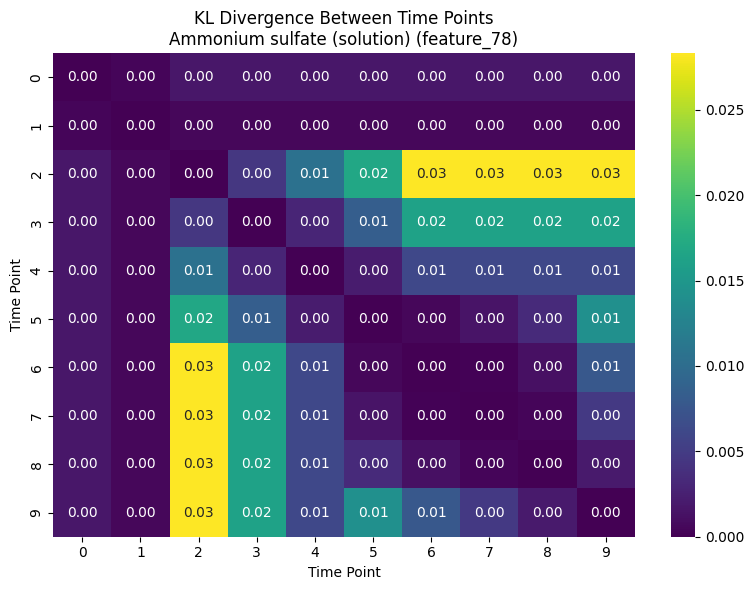


  Ammonia (feature_76)
    KL(Time 0 || Time 1): 0.0003
    KL(Time 0 || Time 2): 0.0019
    KL(Time 0 || Time 3): 0.0022
    KL(Time 0 || Time 4): 0.0029
    KL(Time 0 || Time 5): 0.0035
    KL(Time 0 || Time 6): 0.0045
    KL(Time 0 || Time 7): 0.0055
    KL(Time 0 || Time 8): 0.0079
    KL(Time 0 || Time 9): 0.0081
    KL(Time 1 || Time 2): 0.0007
    KL(Time 1 || Time 3): 0.0009
    KL(Time 1 || Time 4): 0.0016
    KL(Time 1 || Time 5): 0.0021
    KL(Time 1 || Time 6): 0.0032
    KL(Time 1 || Time 7): 0.0043
    KL(Time 1 || Time 8): 0.0068
    KL(Time 1 || Time 9): 0.0070
    KL(Time 2 || Time 3): 0.0002
    KL(Time 2 || Time 4): 0.0008
    KL(Time 2 || Time 5): 0.0014
    KL(Time 2 || Time 6): 0.0027
    KL(Time 2 || Time 7): 0.0041
    KL(Time 2 || Time 8): 0.0068
    KL(Time 2 || Time 9): 0.0070
    KL(Time 3 || Time 4): 0.0002
    KL(Time 3 || Time 5): 0.0007
    KL(Time 3 || Time 6): 0.0020
    KL(Time 3 || Time 7): 0.0029
    KL(Time 3 || Time 8): 0.0051
    KL(Time 3 || Ti

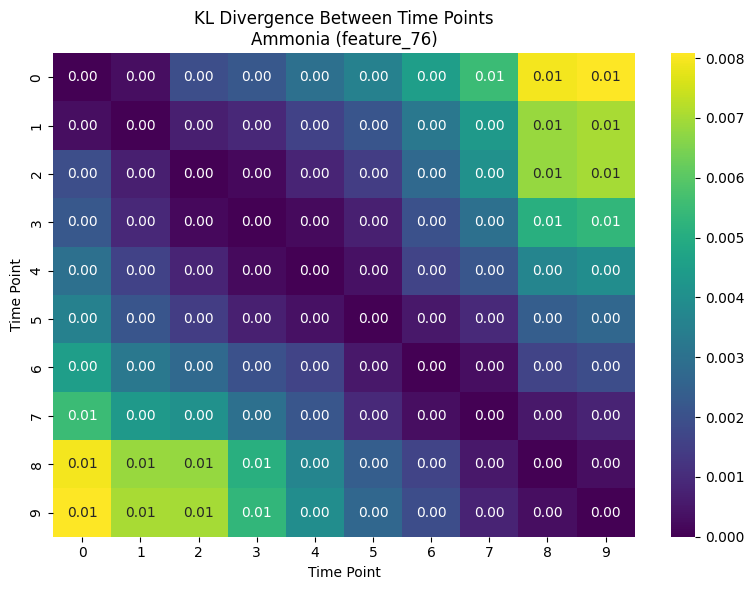


  Zinc compounds (feature_274)
    KL(Time 0 || Time 1): 0.0003
    KL(Time 0 || Time 2): 0.0007
    KL(Time 0 || Time 3): 0.0012
    KL(Time 0 || Time 4): 0.0018
    KL(Time 0 || Time 5): 0.0028
    KL(Time 0 || Time 6): 0.0042
    KL(Time 0 || Time 7): 0.0054
    KL(Time 0 || Time 8): 0.0061
    KL(Time 0 || Time 9): 0.0070
    KL(Time 1 || Time 2): 0.0002
    KL(Time 1 || Time 3): 0.0005
    KL(Time 1 || Time 4): 0.0010
    KL(Time 1 || Time 5): 0.0018
    KL(Time 1 || Time 6): 0.0031
    KL(Time 1 || Time 7): 0.0042
    KL(Time 1 || Time 8): 0.0049
    KL(Time 1 || Time 9): 0.0058
    KL(Time 2 || Time 3): 0.0001
    KL(Time 2 || Time 4): 0.0004
    KL(Time 2 || Time 5): 0.0010
    KL(Time 2 || Time 6): 0.0021
    KL(Time 2 || Time 7): 0.0030
    KL(Time 2 || Time 8): 0.0037
    KL(Time 2 || Time 9): 0.0046
    KL(Time 3 || Time 4): 0.0001
    KL(Time 3 || Time 5): 0.0005
    KL(Time 3 || Time 6): 0.0014
    KL(Time 3 || Time 7): 0.0023
    KL(Time 3 || Time 8): 0.0028
    KL(Time

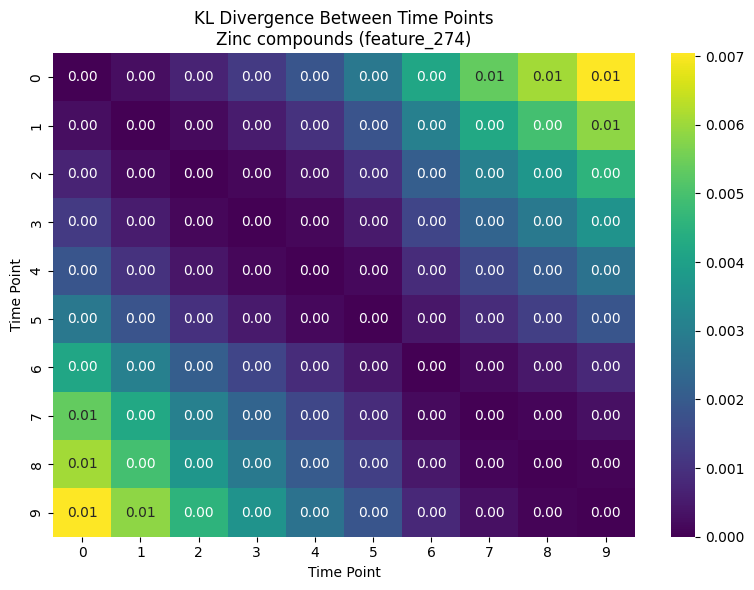

In [4]:
def load_data(model_type, base_path):
    features = np.load(f'{base_path}{model_type}_features.npy')
    targets = np.load(f'{base_path}{model_type}_target.npy')
    index = np.load(f'{base_path}{model_type}_index.npy')
    features_df = pd.read_csv(f'{base_path}{model_type}_features.csv')
    feature_names = features_df['Feature'].tolist()

    print(f"Features shape: {features.shape}")
    print(f"Targets shape: {targets.shape}")
    print(f"Index shape: {index.shape}")

    return features, targets, index, feature_names

def calculate_feature_stats(features):
    # Features dimensions should be: [samples, time_points, features]
    n_samples, n_time_points, n_features = features.shape

    # Calculate mean, variance, and percentage of NaN values for each feature
    feature_stats = []

    for i in range(n_features):
        feature_data = features[:, :, i].flatten()
        total_values = len(feature_data)
        nan_count = np.isnan(feature_data).sum()
        nan_percentage = nan_count / total_values * 100

        # Calculate stats on non-NaN values
        valid_data = feature_data[~np.isnan(feature_data)]
        if len(valid_data) > 0:
            mean_val = np.mean(valid_data)
            var_val = np.var(valid_data)
            min_val = np.min(valid_data)
            max_val = np.max(valid_data)
        else:
            mean_val = var_val = min_val = max_val = np.nan

        feature_stats.append({
            'feature_idx': i,
            'mean': mean_val,
            'variance': var_val,
            'min': min_val,
            'max': max_val,
            'nan_percentage': nan_percentage
        })

    return feature_stats

def calculate_kl_divergence_features(features, feature_names, years, top_n=20):
    # Make sure years is the right shape
    if len(years.shape) > 1:
        years_col = 1  # Assuming year is the second column
        years = years[:, years_col]

    # Get unique years in sorted order
    unique_years = np.sort(np.unique(years))

    # Features dimensions should be: [samples, time_points, features]
    n_samples, n_time_points, n_features = features.shape

    # Calculate feature statistics
    feature_stats = calculate_feature_stats(features)

    # Sort features by variance
    feature_stats.sort(key=lambda x: x['variance'] if not np.isnan(x['variance']) else 0, reverse=True)

    # Select top N features with highest variance
    top_feature_indices = [stat['feature_idx'] for stat in feature_stats[:top_n]]

    # Print top features being analyzed
    print(f"Analyzing KL divergence for top {top_n} features by variance:")
    for idx in top_feature_indices:
        print(f"  {feature_names[idx]} (feature_{idx})")

    # For each feature, calculate KL divergence between consecutive years
    kl_results = {}

    for feature_idx in top_feature_indices:
        feature_name = feature_names[feature_idx]
        feature_kl = []
        year_pairs = []

        print(f"\nAnalyzing KL divergence for: {feature_name} (feature_{feature_idx})")

        for i in range(len(unique_years) - 1):
            year1 = unique_years[i]
            year2 = unique_years[i + 1]
            year_pair = f"{int(year1)}-{int(year2)}"

            # Get data for year1
            year1_mask = (years == year1)
            if np.count_nonzero(year1_mask) > 0:
                year1_data = features[year1_mask, 0, feature_idx].flatten()  # Using time point 0
            else:
                year1_data = np.array([])

            # Get data for year2
            year2_mask = (years == year2)
            if np.count_nonzero(year2_mask) > 0:
                year2_data = features[year2_mask, 0, feature_idx].flatten()  # Using time point 0
            else:
                year2_data = np.array([])

            # Remove NaN values
            year1_data = year1_data[~np.isnan(year1_data)]
            year2_data = year2_data[~np.isnan(year2_data)]

            # Skip if not enough data
            if len(year1_data) < 5 or len(year2_data) < 5:
                print(f"  Skipping {year_pair} - not enough data")
                continue

            # Create histograms with same bins for both years
            min_val = min(np.min(year1_data), np.min(year2_data))
            max_val = max(np.max(year1_data), np.max(year2_data))

            # Create bins
            n_bins = min(30, max(5, len(year1_data) // 10, len(year2_data) // 10))

            try:
                bins = np.linspace(min_val, max_val, n_bins + 1)

                # Create histograms
                hist1, _ = np.histogram(year1_data, bins=bins, density=True)
                hist2, _ = np.histogram(year2_data, bins=bins, density=True)

                # Add a small constant to avoid zeros
                hist1 = hist1 + 1e-10
                hist2 = hist2 + 1e-10

                # Normalize
                hist1 = hist1 / hist1.sum()
                hist2 = hist2 / hist2.sum()

                # Calculate KL divergence
                kl_div = entropy(hist1, hist2)
                print(f"  KL({int(year1)} || {int(year2)}): {kl_div:.4f}")

                feature_kl.append(kl_div)
                year_pairs.append(year_pair)
            except Exception as e:
                print(f"  Error calculating KL divergence for {year_pair}: {e}")

        # Store results for this feature
        if feature_kl:  # Only store if we have some results
            kl_results[f"{feature_name} (feature_{feature_idx})"] = {
                'kl_values': feature_kl,
                'year_pairs': year_pairs
            }

    return kl_results

def plot_kl_divergence(kl_results, title, output_path=None):
    plt.figure(figsize=(14, 8))

    for feature_name, data in kl_results.items():
        if data['kl_values']:  # Check if there are values to plot
            plt.plot(data['year_pairs'], data['kl_values'], marker='o', label=feature_name)

    plt.title(f'KL Divergence Trends - {title}')
    plt.xlabel('Year Pair')
    plt.ylabel('KL Divergence')
    plt.xticks(rotation=45, ha='right')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()

    if output_path:
        plt.savefig(output_path, dpi=300, bbox_inches='tight')

    plt.show()

def compare_kl_between_cancers(bladder_results, lung_results):
    # Find common features in both results
    bladder_features = set(bladder_results.keys())
    lung_features = set(lung_results.keys())
    common_features = bladder_features.intersection(lung_features)

    if not common_features:
        print("No common features found for comparison")
        return

    print(f"Found {len(common_features)} common features for comparison:")
    for feature in common_features:
        print(f"  {feature}")

    # For each common feature, calculate correlation between KL patterns
    correlations = []

    for feature in common_features:
        bladder_data = bladder_results[feature]
        lung_data = lung_results[feature]

        # Find common year pairs
        common_years = set(bladder_data['year_pairs']).intersection(set(lung_data['year_pairs']))

        if len(common_years) > 2:  # Need at least 3 points for meaningful correlation
            # Extract KL values for common years
            common_years = sorted(list(common_years))

            bladder_kl = []
            lung_kl = []

            for year in common_years:
                if year in bladder_data['year_pairs'] and year in lung_data['year_pairs']:
                    bladder_idx = bladder_data['year_pairs'].index(year)
                    lung_idx = lung_data['year_pairs'].index(year)

                    bladder_kl.append(bladder_data['kl_values'][bladder_idx])
                    lung_kl.append(lung_data['kl_values'][lung_idx])

            # Calculate correlation
            if len(bladder_kl) > 2:
                corr = np.corrcoef(bladder_kl, lung_kl)[0, 1]
                correlations.append((feature, corr, len(bladder_kl)))

    # Sort by absolute correlation
    correlations.sort(key=lambda x: abs(x[1]), reverse=True)

    # Print and plot results
    if correlations:
        print("\nCorrelation between bladder and lung cancer KL divergence patterns:")
        for feature, corr, n_years in correlations:
            print(f"  {feature}: r = {corr:.4f} (based on {n_years} year pairs)")

        # Plot top correlations
        plt.figure(figsize=(12, 6))
        features = [x[0] for x in correlations]
        corrs = [x[1] for x in correlations]

        # Show only top 10 if there are many features
        if len(features) > 10:
            features = features[:10]
            corrs = corrs[:10]

        colors = ['blue' if c > 0 else 'red' for c in corrs]
        plt.bar(range(len(corrs)), corrs, color=colors)
        plt.axhline(y=0, color='black', linestyle='-', alpha=0.3)
        plt.xticks(range(len(corrs)), features, rotation=90)
        plt.ylabel('Correlation Coefficient')
        plt.title('Correlation of KL Divergence Patterns between Bladder and Lung Cancer')
        plt.tight_layout()
        plt.show()
    else:
        print("Not enough data to calculate correlations")

def analyze_time_windows(features, feature_names, top_n=5):
    # Features dimensions should be: [samples, time_points, features]
    n_samples, n_time_points, n_features = features.shape

    if n_time_points < 2:
        print("Not enough time points for time window analysis")
        return

    # Calculate variance across time points for each feature
    time_variance = np.zeros(n_features)

    for i in range(n_features):
        # For each sample, calculate variance across time
        sample_variances = []

        for j in range(n_samples):
            time_series = features[j, :, i]
            # Skip if too many NaNs
            if np.isnan(time_series).sum() < n_time_points / 2:
                sample_variances.append(np.nanvar(time_series))

        if sample_variances:
            time_variance[i] = np.mean(sample_variances)

    # Get top features with highest time variance
    top_feature_indices = np.argsort(-time_variance)[:top_n]

    print(f"\nAnalyzing KL divergence across time windows for top {top_n} features:")

    # For each top feature, calculate KL divergence between all time point pairs
    for feature_idx in top_feature_indices:
        feature_name = feature_names[feature_idx]
        print(f"\n  {feature_name} (feature_{feature_idx})")

        # Create KL divergence matrix for all time points
        kl_matrix = np.zeros((n_time_points, n_time_points))

        for t1 in range(n_time_points):
            for t2 in range(t1 + 1, n_time_points):  # Only compute upper triangle
                # Get data for both time points
                data1 = features[:, t1, feature_idx]
                data2 = features[:, t2, feature_idx]

                # Remove NaNs
                valid_idx = ~np.isnan(data1) & ~np.isnan(data2)
                data1 = data1[valid_idx]
                data2 = data2[valid_idx]

                if len(data1) >= 5:  # Need enough data points
                    try:
                        # Create histograms
                        min_val = min(np.min(data1), np.min(data2))
                        max_val = max(np.max(data1), np.max(data2))

                        bins = np.linspace(min_val, max_val, 20)

                        hist1, _ = np.histogram(data1, bins=bins, density=True)
                        hist2, _ = np.histogram(data2, bins=bins, density=True)

                        # Add small constant
                        hist1 = hist1 + 1e-10
                        hist2 = hist2 + 1e-10

                        # Normalize
                        hist1 = hist1 / hist1.sum()
                        hist2 = hist2 / hist2.sum()

                        # Calculate KL divergence (both directions)
                        kl_1_to_2 = entropy(hist1, hist2)
                        kl_2_to_1 = entropy(hist2, hist1)

                        # Use symmetric KL divergence
                        kl_div = (kl_1_to_2 + kl_2_to_1) / 2

                        kl_matrix[t1, t2] = kl_div
                        kl_matrix[t2, t1] = kl_div  # Mirror for plotting

                        print(f"    KL(Time {t1} || Time {t2}): {kl_div:.4f}")
                    except Exception as e:
                        print(f"    Error calculating KL for time points {t1} and {t2}: {e}")

        # Plot heatmap
        plt.figure(figsize=(8, 6))
        sns.heatmap(kl_matrix, annot=True, fmt=".2f", cmap="viridis")
        plt.title(f'KL Divergence Between Time Points\n{feature_name} (feature_{feature_idx})')
        plt.xlabel('Time Point')
        plt.ylabel('Time Point')
        plt.tight_layout()
        plt.show()

# Base path where .npy files are located
base_path = '/content/'  # For Google Colab

# Load bladder and lung cancer data
bladder_features, bladder_targets, bladder_index, bladder_feature_names = load_data('bladder', base_path)
lung_features, lung_targets, lung_index, lung_feature_names = load_data('lung', base_path)

# Calculate KL divergence for bladder cancer
print("KL Divergence Analysis for Bladder Cancer:")
bladder_kl = calculate_kl_divergence_features(bladder_features, bladder_feature_names, bladder_index)

# Plot bladder cancer KL divergence
plot_kl_divergence(bladder_kl, "Bladder Cancer", output_path=f"{base_path}bladder_kl_divergence.png")

# Calculate KL divergence for lung cancer
print("\nKL Divergence Analysis for Lung Cancer:")
lung_kl = calculate_kl_divergence_features(lung_features, lung_feature_names, lung_index)

# Plot lung cancer KL divergence
plot_kl_divergence(lung_kl, "Lung Cancer", output_path=f"{base_path}lung_kl_divergence.png")

# Compare KL divergence patterns between cancer types
print("\nComparing KL Divergence Patterns Between Cancer Types:")
compare_kl_between_cancers(bladder_kl, lung_kl)

# Analyze time windows for bladder cancer
print("\nTime Window Analysis for Bladder Cancer:")
analyze_time_windows(bladder_features, bladder_feature_names)

# Analyze time windows for lung cancer
print("\nTime Window Analysis for Lung Cancer:")
analyze_time_windows(lung_features, lung_feature_names)